In [23]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import datagen

In [24]:

dataset = datagen.load('../Data1')
dp = dataset[0]

im_src = dp.visible_spectrum

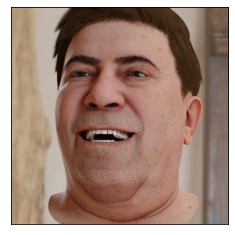

In [25]:
plt.imshow(im_src);
plt.xticks([])
plt.yticks([]);

In [26]:
from skimage.transform import warp
from skimage import data

## Rotation and Translation

In [27]:
#paper_plane= np.array([[1, 0.5, .2], [-0.2, 1.3, 1], [0, 0, 0.5]])
theta  = -10*(np.pi/180)
xtrans = -500
ytrans = -200
scale = 0.7
paper_plane= np.array([[np.cos(theta), -np.sin(theta), xtrans], [np.sin(theta), np.cos(theta), ytrans], [0, 0, scale]])
paper_plane

array([[ 9.84807753e-01,  1.73648178e-01, -5.00000000e+02],
       [-1.73648178e-01,  9.84807753e-01, -2.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  7.00000000e-01]])

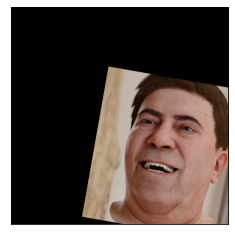

In [28]:

warped = warp(im_src, paper_plane)
plt.imshow(warped);
plt.xticks([])
plt.yticks([]);

## Perspective warp

In [29]:

height, width, dim = im_src.shape

## Define a plane in 3D coordinates, warp image onto this plane

In [30]:
#paper properties 8.5" x 11"
p_width = 0.2#0.2794
p_height = 0.2#0.2159
paperY = 0
paper_tilt = .01

dst_world_4corners= np.array([[p_width/2*-1, paperY,  p_height],
                     [(p_width/2), paperY + paper_tilt, p_height],
                     [(p_width/2) , paperY + paper_tilt, 0] ,
                     [(p_width/2)*-1,paperY, 0]])

# Transform the 4 corner points into image coordiates

In [31]:
#dst_image = toImageCoordiantes(dst_world)
kpts_3d_homogeneous = np.hstack([dst_world_4corners, np.ones((4, 1))])

In [32]:
kpts_3d_cam = (dp.camera_metadata.extrinsic_matrix @ kpts_3d_homogeneous.T).T
kpts_2d_img_homogenous = (dp.camera_metadata.intrinsic_matrix @ kpts_3d_cam.T).T
kpts_2d_img = kpts_2d_img_homogenous[:, :2] / kpts_2d_img_homogenous[:, 2][:, np.newaxis]
kpts_2d_img

array([[  54.37861082,  145.90288865],
       [ 966.77902016,  148.17678387],
       [ 966.77902858, 1057.73488851],
       [  54.37860229, 1061.1457318 ]])

True


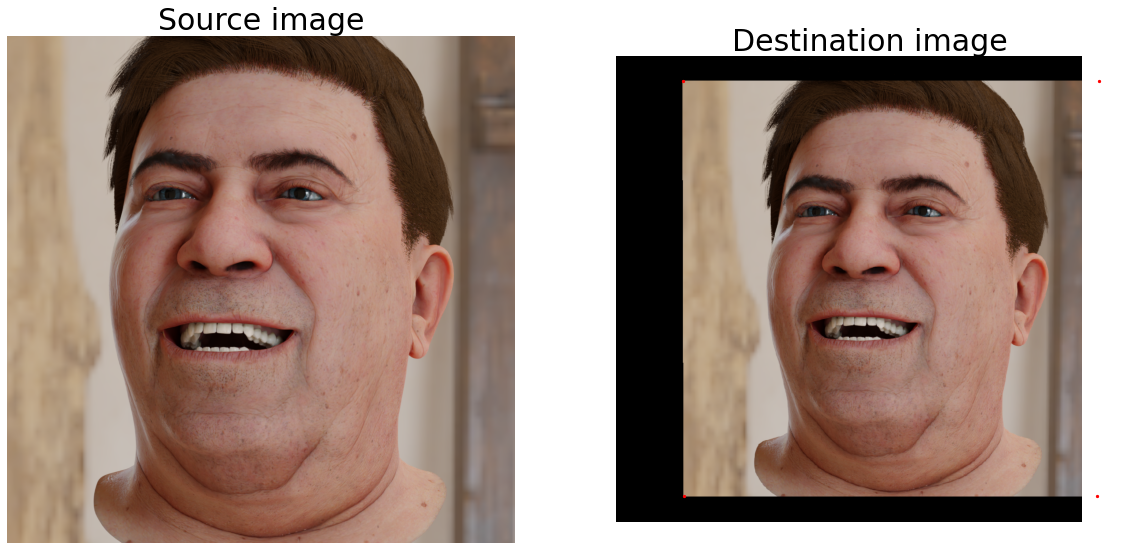

In [33]:
im_dst = im_src.copy()
im_dst[np.all(im_dst, axis=-1)] = (0,0,0)

#init ProjectiveTransform object
pt = transform.ProjectiveTransform()
src = np.array([[ 0., 0.],
       [height-1, 0.],
       [height-1, width-1],
       [ 0., width-1]])

dst = kpts_2d_img

#estimate the transformation
print(pt.estimate(src, dst))


x, y = np.mgrid[:im_dst.shape[0], :im_dst.shape[1]]
dst_indices=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))

#apply transform
src_indices = np.round(pt.inverse(dst_indices), 0).astype(int)

#clip image if it doesnt fit on the destination
valid_idx = np.where((src_indices[:,0] < height) & (src_indices[:,1] < width) & (src_indices[:,0] >= 0) & (src_indices[:,1] >= 0))

dst_indicies_valid = dst_indices[valid_idx]
src_indicies_valid = src_indices[valid_idx]

im_dst[dst_indicies_valid[:,0],dst_indicies_valid[:,1]] = im_src[src_indicies_valid[:,0],src_indicies_valid[:,1]]

#plot the original and warped image
plt.figure(figsize=(15,10))
plt.imshow(im_dst), plt.axis('off'), plt.title('Output Image', size=20)
#plt.savefig('data/homography_out.png')
plt.close()

plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(im_src, cmap='gray'), plt.axis('off'), plt.title('Source image', size=30)
plt.subplot(122), plt.imshow(im_dst, cmap='gray'), plt.axis('off'), plt.title('Destination image', size=30)
plt.subplot(122).scatter(dst[:,1],dst[:,0], s=5, c=[[1,0,0]])
plt.show()

Left: Original Image. Right: Red Dots represent the 4 corner of the destination plane. Image warped onto destination plane.